<a href="https://colab.research.google.com/github/alimoorreza/cs195-fall24-notes/blob/main/cs195_object_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Object detection: training/fine-tuning a pre-trained Faster R-CNN model**
- [Microsoft COCO (Common Object in COntext)](https://cocodataset.org/#explore)
- This model has been trained on the COCO dataset and can recognize 91 objects, including `person`, `dog`, and `cat`.

## We will fine-tune the Faster R-CNN detector using the pedestrian dataset known as PennFudanPed.
- This dataset contains images of people walking on the streets. Our goal is to train the model to enhance its ability to detect pedestrians.

## Dataset for fine-tuning Faster R-CNN
- [https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)
- I have uploaded the dataset on Blackboard as well; you could download it from there as well.
- Alternately, please execute the following lines or manually download this dataset and upload it to your Google Drive:
  - !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
  - !unzip PennFudanPed.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/cs195_fall24/detection/'

Mounted at /content/drive


In [2]:
%%shell
git clone https://github.com/alimoorreza/cs195_fall24_detection.git

cp cs195_fall24_detection/utils.py ./
cp cs195_fall24_detection/transforms.py ./
cp cs195_fall24_detection/coco_eval.py ./
cp cs195_fall24_detection/engine.py ./
cp cs195_fall24_detection/coco_utils.py ./

Cloning into 'cs195_fall24_detection'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 18.38 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
%%shell
pip install cython

boundding boxes: 
[[84, 24, 164, 293], [139, 5, 296, 308]]


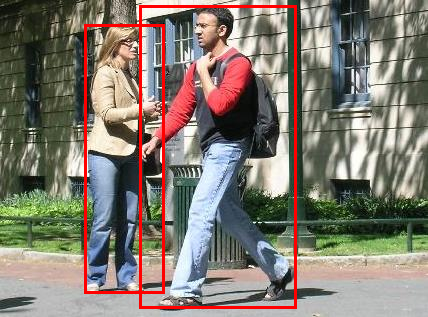

In [5]:
# a sample visualization of bound-boxes associated with the objects (pedestrian)

import numpy as np
from PIL import Image, ImageDraw

mask = Image.open(root + '/PennFudanPed/PedMasks/PennPed00089_mask.png')
mask = np.array(mask)

# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

print(f"boundding boxes: \n{boxes}")

# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image = Image.open(root + '/PennFudanPed/PNGImages/PennPed00089.png')
draw      = ImageDraw.Draw(rgb_image)

# draw rectangular bouding boxes on the image
for box in boxes:
    draw.rectangle(box, outline="red", width=3)

# show the image
rgb_image


In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path    = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path   = os.path.join(self.root, "PedMasks", self.masks[idx])
        img         = Image.open(img_path).convert("RGB")
        mask        = Image.open(mask_path) # note that we haven't converted the mask to RGB because each color corresponds to a different instance with 0 being background



        mask        = np.array(mask)
        obj_ids     = np.unique(mask) # instances are encoded as different colors
        obj_ids     = obj_ids[1:]     # first id is the background, so remove it

        # split the color-encoded mask into a set of binary masks
        masks       = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs    = len(obj_ids)
        boxes       = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes       = torch.as_tensor(boxes, dtype=torch.float32)
        labels      = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        masks       = torch.as_tensor(masks, dtype=torch.uint8)

        image_id    = torch.tensor([idx])
        area        = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd     = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd

        target              = {}
        target["boxes"]     = boxes
        target["labels"]    = labels
        target["masks"]     = masks
        target["image_id"]  = image_id
        target["area"]      = area
        target["iscrowd"]   = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

##**Notice below that we are saving attributes such as `boxes,` `labels,` and `masks` for each image, which will be useful during the training of our models.**

In [7]:
# testing the Dataset class we just created
dataset = PennFudanDataset(root + '/PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [8]:
from engine import train_one_epoch, evaluate
# if it fails to execute, then open coco_eval.py and comment out the statement: import torch._six
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#**Subset: a useful utility function**
- [torch.utils.data.Subset()](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)
  - a PyTorch utility function for retrieving a subset of images from a folder at specified indices
  - provide the folder name as well as a set of indices
  - for a specific example, please see below

In [53]:
# use our dataset and defined transformations
from torch.utils.data import Subset # for partitioning the folder in making train+test splits
torch.manual_seed(1)

dataset_test      = PennFudanDataset(root + '/PennFudanPed/', get_transform(train=False))
dataset_train     = PennFudanDataset(root + '/PennFudanPed/', get_transform(train=True))


# split the dataset in train and test set
random_indices    = torch.randperm(len(dataset_train)).tolist()
total_test_image  = 50                                                            # you can adjust the number of samples you want to include in the TEST SPLIT
dataset_test      = Subset(dataset_test,  random_indices[-total_test_image:])     # place the last 50 randomly shuffled images in the TEST SPLIT
dataset_train     = Subset(dataset_train, random_indices[:-total_test_image])     # place rest of the images in the TRAIN SPLIT

print('Train sample indices: ', random_indices[:-total_test_image])
print('Test sample indices: ', random_indices[-total_test_image:])


# define training and test data loaders

# you don't need to shuffle the test samples because they don't affect the network training
data_loader_test  = torch.utils.data.DataLoader(
                      dataset_test, batch_size=1, shuffle=False, num_workers=2,
                      collate_fn=utils.collate_fn)

# but you should (or must) shuffle the training examples
data_loader_train = torch.utils.data.DataLoader(
                      dataset_train, batch_size=2, shuffle=True, num_workers=2,
                      collate_fn=utils.collate_fn)




Train sample indices:  [155, 62, 1, 87, 73, 138, 121, 118, 61, 19, 58, 86, 36, 52, 39, 80, 148, 23, 108, 16, 20, 161, 124, 78, 8, 101, 132, 66, 33, 69, 128, 160, 53, 100, 83, 158, 85, 150, 166, 2, 55, 91, 51, 57, 89, 115, 156, 71, 63, 103, 134, 140, 102, 11, 59, 49, 163, 127, 45, 68, 136, 149, 137, 116, 159, 35, 10, 143, 17, 82, 99, 56, 42, 139, 126, 40, 113, 50, 123, 120, 25, 41, 38, 152, 81, 105, 141, 154, 164, 95, 130, 107, 70, 46, 15, 14, 117, 18, 7, 111, 76, 133, 32, 74, 93, 60, 72, 4, 167, 27, 153, 24, 165, 146, 157, 44, 106, 0, 30, 125]
Test sample indices:  [34, 84, 145, 135, 131, 3, 122, 77, 168, 169, 64, 142, 144, 88, 26, 47, 22, 65, 90, 48, 21, 43, 29, 9, 119, 92, 109, 104, 31, 110, 112, 96, 28, 13, 75, 151, 67, 79, 5, 98, 37, 6, 54, 129, 162, 94, 114, 147, 12, 97]


#FasterRCNN Trainning and Inference
- [Faster RCNN PyTorch Reference](https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html)

In [27]:
import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn        # import the pretrained model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # you need to adjust the total number of output predictors (eg, i) pedestrian ii) backbround), as they might differ from those in pretrained dataset MS COCO which had 91 classes



class FasterRCNN(nn.Module):

  def __init__(self, num_classes):
    super(FasterRCNN, self).__init__()

    self.model = fasterrcnn_resnet50_fpn(pretrained=True)                               # load the detection model pre-trained on MS-COCO; retain the network backbone but replace the predictor head for fine-tuning

    in_features = self.model.roi_heads.box_predictor.cls_score.in_features              # get the number of input features for the classifier

    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    # replace the pre-trained predictor head with a new one (both FastRCNN and FasterRCNN use the same predictor)

  def forward(self, x, target=None):
    output = self.model(x, target)
    return output


#**Group task#1**
> ### **Finish fine-tuning the pretrained Faster R-CNN model using PennFudanPed dataset**

> Write down your observations:

>> How are the loss values changing during each epoch? Are they decreasing or increasing?

>> How well is the model performing on the test split? The evaluation metrics are precision and recall (the higher, the better). Are these numbers improving or decreasing?

In [ ]:
# TRAINIING
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

model = FasterRCNN(num_classes)

model.to(device)

# construct an optimizer for fine-tuning
params      = [p for p in model.parameters() if p.requires_grad]
optimizer   = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

# start traininig or fine-tuning

for epoch in range(num_epochs):

    # we imported this method from the utility scripts for detection we downloaded earlier: /content/engine.py

    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10) # train for one epoch, printing every 10 iterations (NOTE: this function is inside engine.py file)

    lr_scheduler.step() # update the learning rate

    evaluate(model, data_loader_test, device=device) # evaluate on the test dataset (NOTE: this function is inside engine.py file)

# save the trained model
model_save_dir = root + '/output'
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)
    print(f"Directory {model_save_dir} created.")
else:
    print(f"Directory {model_save_dir} already exists.")

torch.save(model.state_dict(), model_save_dir + '/faster_rcnn_model_finetuned.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 99.5MB/s]


#**Group task#2**
> ### **Finish runing the inference using the fine-tuned Faster R-CNN model**

> Write down your observations:

>> How accurate the detections were, how many objects were correctly identified, and how many were missed. Also, note if any objects were missed due to occlusion or other challenges.

<ipython-input-62-da3d4cfb7558>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/cs195_fall24/detection/output/fast

Inference on test sample# 3
[{'boxes': tensor([[ 58.3051,  37.5971, 195.9144, 327.6997],
        [291.8765, 201.2575, 291.9945, 208.6939],
        [ 73.7313,  42.9762, 201.9721, 201.5472]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0812, 0.0518], device='cuda:0', grad_fn=<IndexBackward0>)}]


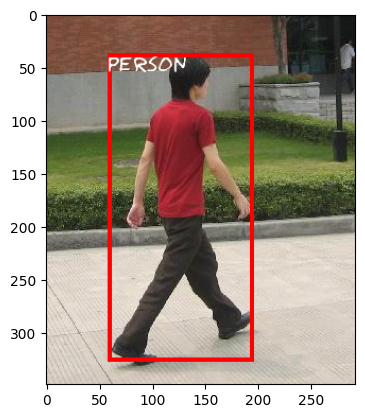

In [62]:
# TESTING AND VISUALIZATION

# visualization of bound-boxes associated with the objects (person)
import pdb
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
font                = ImageFont.truetype("/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf", 20)


device              = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
PENNFUDAN_INSTANCE_CATEGORY_NAMES = {0:'background', 1:'person'}
num_classes         = 2
model               = FasterRCNN(num_classes)
model.to(device)
model.load_state_dict(torch.load(root + '/output/faster_rcnn_model_finetuned.pth'))
model.eval()

test_sample_index = 0
end_offset        = 3

data_iter = iter(data_loader_test)
#for i, batch in enumerate(data_loader_test, start=start_offset):
while test_sample_index < len(data_loader_test):

    images, targets  = next(data_iter)
    print(f"Inference on test sample# {test_sample_index}")

    images            = list(image.to(device) for image in images)
    targets           = [{k: v for k, v in t.items()} for t in targets]
    predictions       = model(images)
    print(predictions)


    # visualize one of the images before running the inference
    SELECTED_IMAGE_INDEX = 0 # Change it to one of the values: 0, 1, 2, or 3. This will display the results for different images.
    img               = images[SELECTED_IMAGE_INDEX].cpu().numpy() # we have a batch of 4 images
    img               = img.transpose(1, 2, 0)
    #print(f"image shape is: {img.shape}")


    # draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
    rgb_image         = 255*images[SELECTED_IMAGE_INDEX].cpu().numpy() # after reading as PIL.Image, the array entries get values that range between [0-1]
    rgb_image         = rgb_image.transpose(1, 2, 0)
    rgb_image         = rgb_image.astype(np.uint8)
    rgb_pil_img       = Image.fromarray(rgb_image)
    rgb_pil_img       = rgb_pil_img.convert('RGB')
    draw              = ImageDraw.Draw(rgb_pil_img)

    # draw rectangular bouding boxes on the image
    boxes             = predictions[SELECTED_IMAGE_INDEX]['boxes']
    labels            = predictions[SELECTED_IMAGE_INDEX]['labels']
    scores            = predictions[SELECTED_IMAGE_INDEX]['scores']

    font_size         = 70

    for i in range(len(boxes)):
        box         = boxes[i].detach().cpu().numpy()
        box         = box.astype(int)
        label_id    = labels[i].cpu()
        label_name  = PENNFUDAN_INSTANCE_CATEGORY_NAMES[label_id.item()]
        score       = scores[i]
        # print(f"bounding boxes: \n{box} for label={label_name}")

        # draw a rectangular bounding box on the image to display the detection result.
        if score > 0.5: # only display the detected objects with reliable predictions.

          draw.rectangle([box[0], box[1], box[2], box[3] ], outline="red", width=4)
          text_x_coord, text_y_coord = box[0], box[1]
          draw.text((text_x_coord, text_y_coord), label_name, font=font, fill=(255, 255, 255))



    # show the image
    if test_sample_index == end_offset:

      plt.imshow(np.asarray(rgb_pil_img))
      #pdb.set_trace()
      break

    # adjust the counter
    test_sample_index = test_sample_index + 1

